# Radiocarbon

In this tutorial, we will simulate the radiocarbon age using the AIBECS by
1. defining the transport `T(p)` and the sources and sinks `G(x,p)`,
1. defining the parameters `p`,
1. generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated radiocarbon age.

> *Note*
> Although this tutorial is self-contained, it is slightly more complicated than the first tutorial for simulating the ideal age.
> (So do not hesitate to start with the ideal-age tutorial if you wish.)

The tracer equation for radiocarbon is

$$\big(\partial_t + \mathbf{T} \big) \boldsymbol{R} = \frac{\lambda}{h} (\overline{\boldsymbol{R}}_\mathsf{atm} - \boldsymbol{R}) (\boldsymbol{z} ≤ h) - \boldsymbol{R} / \tau.$$

where the first term on the right of the equal sign represents the air–sea gas exchange with a piston velocity $λ$ over a depth $h$ and the second term represents the radioactive decay of radiocarbon with timescale $\tau$.

> Note:
> We need not specify the value of the atmospheric radiocarbon concentration because it is not important for determining the age of a water parcel — only the relative concentration $\boldsymbol{R}/\overline{\boldsymbol{R}}_\mathsf{atm}$ matters.

We start by selecting the circulation for Radiocarbon.
.)
(And this time, we are using the OCCA matrix by *Forget* [1](https://doi.org/10.1175/2009JPO4043.1).)

In [1]:
using AIBECS
grd, T_OCCA = OCCA.load()

┌ Warning: Over-writing registration of the datadep
│   name = "AIBECS-OCCA"
└ @ DataDeps ~/.julia/packages/DataDeps/ooWXe/src/registration.jl:15
┌ Info: You are about to use the OCCA model.
│ If you use it for research, please cite:
│ 
│ - Forget, G., 2010: Mapping Ocean Observations in a Dynamical Framework: A 2004–06 Ocean Atlas. J. Phys. Oceanogr., 40, 1201–1221, https://doi.org/10.1175/2009JPO4043.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
└ (Look for the "Forget_2010" key.)


(, sparse([1, 2, 9551, 9606, 1, 2, 3, 57, 9552, 9607  …  79928, 84632, 84659, 84660, 84661, 79891, 79929, 84633, 84660, 84661], [1, 1, 1, 1, 2, 2, 2, 2, 2, 2  …  84660, 84660, 84660, 84660, 84660, 84661, 84661, 84661, 84661, 84661], [2.2827161967151829e-7, 1.8030621712982388e-10, -2.202759122121374e-7, -1.669794081839543e-8, -8.32821319857397e-8, 3.645587487556812e-7, -2.4345873581518986e-8, 2.346272528650749e-8, -3.294980961099172e-7, 6.798120022902578e-9  …  -2.337773104642457e-8, -1.0853897038905248e-8, -2.4801404742669764e-8, 7.658935248883193e-8, -2.49410804832536e-8, -2.2788300189327118e-9, -3.386139290468414e-8, -2.0539768803799346e-8, -1.8193948479846445e-8, 5.86467452504204e-8], 84661, 84661))

The local sources and sinks are simply given by

In [2]:
function G(R,p)
    @unpack λ, h, Ratm, τ = p
    return @. λ / h * (Ratm - R) * (z ≤ h) - R / τ
end

G (generic function with 1 method)

We can define `z` via

In [3]:
z = depthvec(grd)

84661-element Vector{Float64}:
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
    ⋮
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25

In this tutorial we will specify some units for the parameters.
Such features **must** be imported to be used

In [4]:
import AIBECS: @units, units

We define the parameters using the dedicated API from the AIBECS, including keyword arguments and units this time

In [5]:
@units struct RadiocarbonParameters{U} <: AbstractParameters{U}
    λ::U    | u"m/yr"
    h::U    | u"m"
    τ::U    | u"yr"
    Ratm::U | u"M"
end

units (generic function with 20 methods)

For the air–sea gas exchange, we use a constant piston velocity $\lambda$ of 50m / 10years.
And for the radioactive decay we use a timescale $\tau$ of 5730/log(2) years.

In [6]:
p = RadiocarbonParameters(λ = 50u"m"/10u"yr",
                          h = grd.δdepth[1],
                          τ = 5730u"yr"/log(2),
                          Ratm = 42.0u"nM")

 Row │ Symbol  Value      Unit
     │ Symbol  Float64    FreeUnit…
─────┼──────────────────────────────
   1 │ λ          5.0     m yr⁻¹
   2 │ h         50.0     m
   3 │ τ       8266.64    yr
   4 │ Ratm       4.2e-8  M

> *Note*
> The parameters are converted to SI units when unpacked.
>  When you specify units for your parameters, you must supply their values in that unit.

We build the state function `F` and the corresponding steady-state problem (and solve it) via

In [7]:
F = AIBECSFunction(T_OCCA, G)
x = zeros(length(z)) # an initial guess
prob = SteadyStateProblem(F, x, p)
R = solve(prob, CTKAlg()).u

84661-element Vector{Float64}:
 3.781368293693143e-5
 3.7757899707203986e-5
 3.6605707902986216e-5
 3.707009029891931e-5
 3.715744797475248e-5
 3.7158399272783746e-5
 3.707936439247613e-5
 3.7149283799004885e-5
 3.723285923778942e-5
 3.7354960954899674e-5
 ⋮
 3.638493414383458e-5
 3.638153292381407e-5
 3.637308898920067e-5
 3.638148729939723e-5
 3.6416713815628925e-5
 3.645599798864905e-5
 3.650695782714463e-5
 3.652218255431881e-5
 3.65358840956717e-5

This should take a few seconds on a laptop.
Once the radiocarbon concentration is computed, we can convert it into the corresponding age in years, via

In [8]:
@unpack τ, Ratm = p
C14age = @. log(Ratm / R) * τ * u"s" |> u"yr"

84661-element Vector{Quantity{Float64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, nothing}}}:
  867.9858872977056 yr
  880.1899484003853 yr
 1136.3776304296994 yr
 1032.1660922538545 yr
 1012.7082189816208 yr
 1012.4965806539328 yr
 1030.0982249324732 yr
 1014.5247521963447 yr
  995.9480200993163 yr
   968.882685482441 yr
                     ⋮
  1186.385775950803 yr
 1187.1585679087918 yr
 1189.0774285373586 yr
  1187.168934733754 yr
  1179.168598531876 yr
 1170.2558452942267 yr
 1158.7084282581272 yr
 1155.2616567595655 yr
 1152.1609520259226 yr

and plot it at 700 m using the `horizontalslice` Plots recipe

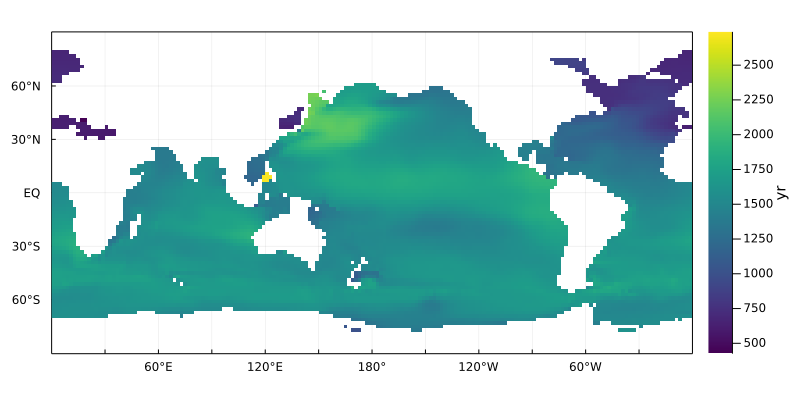

In [9]:
using Plots
plothorizontalslice(C14age, grd, depth=700u"m", color=:viridis)

look at a zonal average using the `zonalaverage` plot recipe

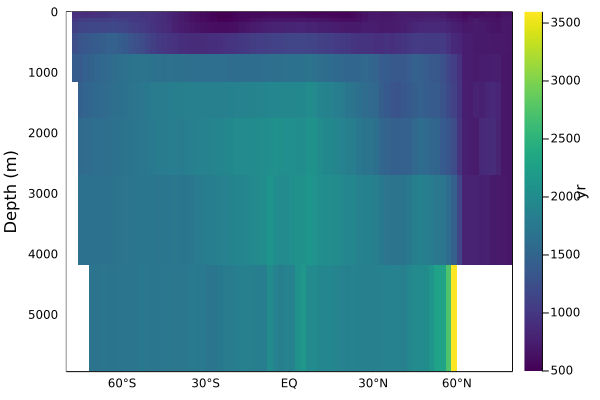

In [10]:
plotzonalaverage(C14age, grd; color=:viridis)

or look at a meridional slice through the Atlantic at 30°W using the `meridionalslice` plot recipe

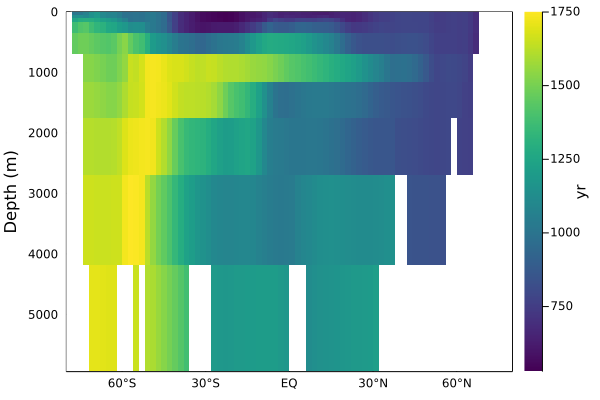

In [11]:
plotmeridionalslice(C14age, grd, lon=-30, color=:viridis)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*